# CLIP vs DCNN内部表現の比較

CLIPとDCNN（Deep Convolutional Neural Network）の内部表現を比較し、4つのカテゴリ（主観的価値、健康度、色、栄養価）における説明力を可視化します。

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src import DATA_PATH, ROOT_PATH

sns.set_theme(font="BIZ UDPGothic")
sns.set_style("whitegrid")
plt.rcParams["font.family"] = ["Arial"]

# カラーパレット設定
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # tab10パレットの最初の4色
gray_color = "#808080"  # DCNN用のグレー

In [2]:
# CLIPの結果を読み込み
clip_result_df = pd.read_csv(
    os.path.join(
        DATA_PATH,
        "output",
        "activation_regression",
        "clip",
        "pca",
        "result_activation_features_regression.csv",
    ),
    index_col=0,
)

print(f"CLIPデータの形状: {clip_result_df.shape}")
print(f"CLIPデータの列: {list(clip_result_df.columns)}")

CLIPデータの形状: (14, 81)
CLIPデータの列: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80']


In [3]:
# DCNNの結果を読み込み
dcnn_result_df = pd.read_csv(
    os.path.join(
        DATA_PATH,
        "output", 
        "activation_regression",
        "pca",
        "v2_result_activation_features_regression.csv",
    ),
    index_col=0,
)

print(f"DCNNデータの形状: {dcnn_result_df.shape}")
print(f"DCNNデータの列: {list(dcnn_result_df.columns)}")

# 具体的なインデックスとデータを確認
print("\n=== DCNN インデックス確認 ===")
print(f"Index: {list(dcnn_result_df.index)}")
print("\n=== res_L_mean のデータ ===")
if 'res_L_mean' in dcnn_result_df.index:
    print(dcnn_result_df.loc['res_L_mean'])
else:
    print("res_L_mean がインデックスに存在しません")

DCNNデータの形状: (14, 36)
DCNNデータの列: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35']

=== DCNN インデックス確認 ===
Index: ['res_L_mean', 'res_H_mean', 'res_T_mean', 'kcal_100g', 'protein_100g', 'fat_100g', 'carbs_100g', 'kcal_total', 'grams_total', 'red', 'green', 'blue', 'is_processed_foods', 'is_testy']

=== res_L_mean のデータ ===
0     0.193904
1     0.277484
2     0.128662
3     0.261385
4     0.296785
5     0.170311
6     0.299785
7     0.340144
8     0.331906
9     0.283792
10    0.522143
11    0.504538
12    0.417798
13    0.584047
14    0.644198
15    0.630750
16    0.784617
17    0.794336
18    0.801690
19    0.805156
20    0.888644
21    0.834809
22    0.873547
23    0.864770
24    0.904784
25    0.851390
26    0.921963
27    0.871072
28    0.891262
29    0.903033
30    0.898746
31    0.909509
32    0.901077
33    0.928795
34    0.943

In [4]:
def process_data(result_df, group_dict, rolling_window=7, step=7):
    """Ridge回帰結果データを処理して可視化用のデータフレームを作成"""
    melt_df = (
        result_df.reset_index()
        .melt(
            id_vars=["index"],
            var_name="Layer",
            value_name="Score",
        )
        .rename(columns={"index": "attribute"})
    )
    melt_df["Layer"] = melt_df["Layer"].astype(str).str.extract(r"(\d+)").astype(int)
    
    df_list = []
    for key, attrs in group_dict.items():
        attr_df = pd.DataFrame(
            melt_df[melt_df["attribute"].isin(attrs)]
            .groupby("Layer")["Score"]
            .mean().sort_index()
            .rolling(window=rolling_window, min_periods=1, step=step)
            .mean()
            .dropna()
            .reset_index(drop=True)
        )
        attr_df["attr"] = key
        attr_df.index += 1
        df_list.append(attr_df)
    
    return pd.concat(df_list)

In [5]:
# CLIPデータの処理
clip_group_dict = {
    "Subjective value": ["res_L_mean"],
    "Healthiness": ["res_H_mean"],
    "Color (RGB)": ["blue", "green", "red"],
    "Nutritional value": ["protein_100g", "fat_100g", "carbs_100g"],
}

clip_data = process_data(clip_result_df, clip_group_dict, rolling_window=7, step=7)
clip_data["model"] = "CLIP"
print("CLIPデータ処理完了")
print(clip_data.head())

CLIPデータ処理完了
      Score              attr model
1  0.228228  Subjective value  CLIP
2  0.202346  Subjective value  CLIP
3  0.187042  Subjective value  CLIP
4  0.227227  Subjective value  CLIP
5  0.260370  Subjective value  CLIP


In [6]:
# DCNNデータの処理
dcnn_group_dict = {
    "Subjective value": ["res_L_mean"],
    "Healthiness": ["res_H_mean"],
    "Color (RGB)": ["blue", "green", "red"],
    "Nutritional value": ["kcal_100g", "protein_100g", "fat_100g", "carbs_100g"],
}

dcnn_data = process_data(dcnn_result_df, dcnn_group_dict, rolling_window=3, step=3)
dcnn_data["model"] = "DCNN"
print("DCNNデータ処理完了")
print(dcnn_data.head())

# データの詳細確認
print("\n=== DCNN データの詳細確認 ===")
for category in ["Subjective value", "Healthiness", "Color (RGB)", "Nutritional value"]:
    cat_data = dcnn_data[dcnn_data["attr"] == category]
    print(f"{category}: {len(cat_data)} データポイント")
    if len(cat_data) > 0:
        print(f"  - Score範囲: {cat_data['Score'].min():.3f} ~ {cat_data['Score'].max():.3f}")
        print(f"  - インデックス範囲: {cat_data.index.min()} ~ {cat_data.index.max()}")
    else:
        print(f"  - データなし")

print("\n=== CLIP データの詳細確認 ===")
for category in ["Subjective value", "Healthiness", "Color (RGB)", "Nutritional value"]:
    cat_data = clip_data[clip_data["attr"] == category]
    print(f"{category}: {len(cat_data)} データポイント")
    if len(cat_data) > 0:
        print(f"  - Score範囲: {cat_data['Score'].min():.3f} ~ {cat_data['Score'].max():.3f}")
        print(f"  - インデックス範囲: {cat_data.index.min()} ~ {cat_data.index.max()}")
    else:
        print(f"  - データなし")

DCNNデータ処理完了
      Score              attr model
1  0.193904  Subjective value  DCNN
2  0.222510  Subjective value  DCNN
3  0.255627  Subjective value  DCNN
4  0.318614  Subjective value  DCNN
5  0.481493  Subjective value  DCNN

=== DCNN データの詳細確認 ===
Subjective value: 12 データポイント
  - Score範囲: 0.194 ~ 0.913
  - インデックス範囲: 1 ~ 12
Healthiness: 12 データポイント
  - Score範囲: 0.330 ~ 0.761
  - インデックス範囲: 1 ~ 12
Color (RGB): 12 データポイント
  - Score範囲: 0.826 ~ 0.943
  - インデックス範囲: 1 ~ 12
Nutritional value: 12 データポイント
  - Score範囲: 0.139 ~ 0.579
  - インデックス範囲: 1 ~ 12

=== CLIP データの詳細確認 ===
Subjective value: 12 データポイント
  - Score範囲: 0.187 ~ 0.546
  - インデックス範囲: 1 ~ 12
Healthiness: 12 データポイント
  - Score範囲: 0.340 ~ 0.852
  - インデックス範囲: 1 ~ 12
Color (RGB): 12 データポイント
  - Score範囲: 0.838 ~ 0.988
  - インデックス範囲: 1 ~ 12
Nutritional value: 12 データポイント
  - Score範囲: 0.104 ~ 0.642
  - インデックス範囲: 1 ~ 12



Subjective value - CLIP data: 12 points
  CLIP score range: 0.187 - 0.546
  DCNN: Subjective value is hidden by design

Healthiness - CLIP data: 12 points
  CLIP score range: 0.340 - 0.852
Healthiness - DCNN data: 12 points
  DCNN score range: 0.330 - 0.761

Color (RGB) - CLIP data: 12 points
  CLIP score range: 0.838 - 0.988
Color (RGB) - DCNN data: 12 points
  DCNN score range: 0.826 - 0.943

Nutritional value - CLIP data: 12 points
  CLIP score range: 0.104 - 0.642
Nutritional value - DCNN data: 12 points
  DCNN score range: 0.139 - 0.579


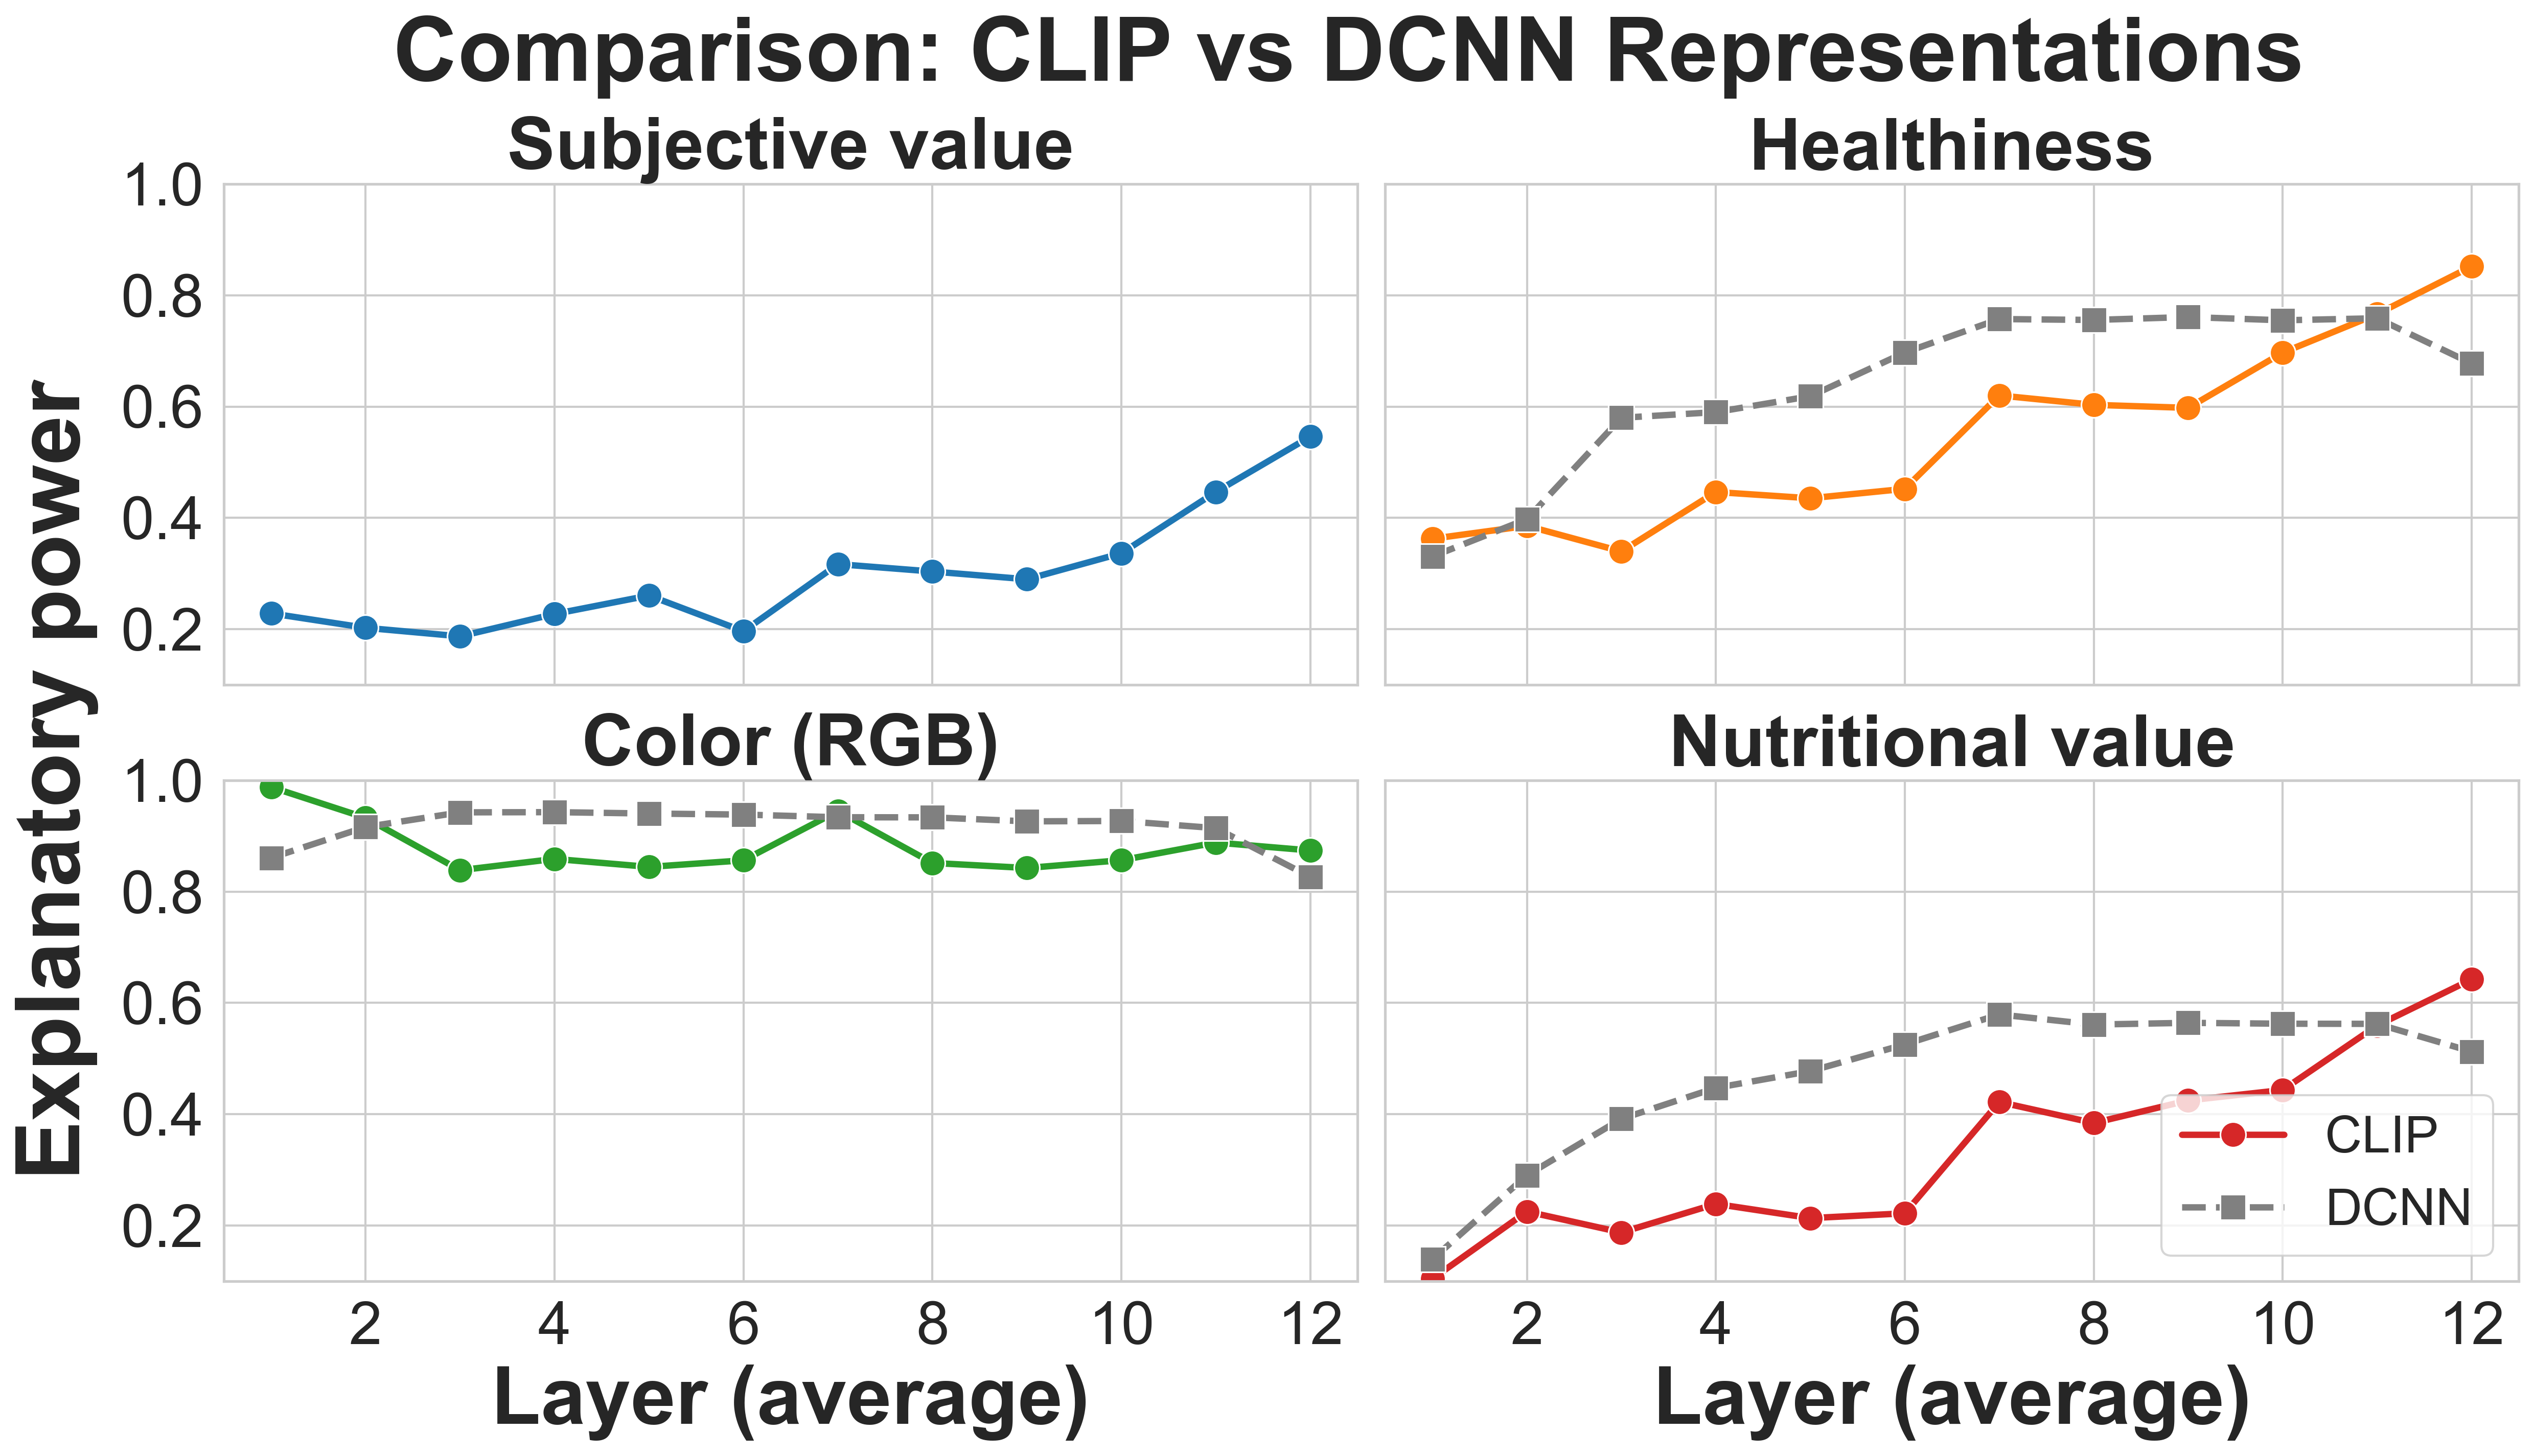

グラフを保存しました: /home/yuhi-aoki/dev/foodReward/data/output/activation_regression/comparison_clip_dcnn.png


In [7]:
# 比較グラフの作成
fig, axes = plt.subplots(2, 2, figsize=(16, 9), dpi=300)

# カテゴリごとに処理
for i, category in enumerate(["Subjective value", "Healthiness", "Color (RGB)", "Nutritional value"]):
    ax = axes.flatten()[i]
    
    # CLIPデータをプロット（カラー）
    clip_cat_data = clip_data[clip_data["attr"] == category]
    print(f"\n{category} - CLIP data: {len(clip_cat_data)} points")
    if not clip_cat_data.empty:
        print(f"  CLIP score range: {clip_cat_data['Score'].min():.3f} - {clip_cat_data['Score'].max():.3f}")
        sns.lineplot(
            data=clip_cat_data.reset_index(),
            x="index",
            y="Score",
            color=colors[i],
            marker="o",
            markersize=12,
            linewidth=3,
            label="CLIP",
            ax=ax
        )
    else:
        print(f"  CLIP: No data for {category}")
    
    # DCNNデータをプロット（グレー）- 主観的価値は非表示
    if category != "Subjective value":
        dcnn_cat_data = dcnn_data[dcnn_data["attr"] == category]
        print(f"{category} - DCNN data: {len(dcnn_cat_data)} points")
        if not dcnn_cat_data.empty:
            print(f"  DCNN score range: {dcnn_cat_data['Score'].min():.3f} - {dcnn_cat_data['Score'].max():.3f}")
            sns.lineplot(
                data=dcnn_cat_data.reset_index(),
                x="index",
                y="Score",
                color=gray_color,
                marker="s",
                markersize=12,
                linewidth=3,
                label="DCNN",
                linestyle="--",
                ax=ax
            )
        else:
            print(f"  DCNN: No data for {category}")
    else:
        print(f"  DCNN: Subjective value is hidden by design")
    
    # グラフの設定
    ax.set_ylim(0.10, 1)
    ax.set_xlim(0.5, 12.5)
    
    # X軸の設定
    if i > 1:  # 下段のグラフのみ
        ax.set_xlabel("Layer (average)", fontsize=38, fontweight="bold")
        ax.tick_params(axis='x', labelsize=28)
    else:
        ax.set_xlabel("")
        ax.set_xticklabels([])
    
    # Y軸の設定
    if i % 2 == 0:  # 左側のグラフのみ
        ax.set_ylabel("")
        ax.tick_params(axis='y', labelsize=28)
        # Y軸の目盛りを統一
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    else:
        ax.set_ylabel("")
        ax.tick_params(axis='y', labelsize=28)
        # 右側も同じ目盛りを設定するが、ラベルは非表示
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels([])
    
    # タイトルの設定
    ax.set_title(category, fontsize=34, fontweight="bold", pad=5)
    
    # 凡例の設定（右下のグラフのみ）
    if i == 3:
        ax.legend(fontsize=24, loc="lower right", framealpha=0.8)
    else:
        ax.legend().set_visible(False)

# 全体のタイトルとラベル
plt.tight_layout()
plt.text(
    s="Explanatory power",
    x=-14,
    y=1,
    fontsize=42,
    fontweight="bold",
    va="center",
    rotation=90,
)
plt.text(
    x=-10,
    y=2.3,
    s="Comparison: CLIP vs DCNN Representations",
    fontsize=42,
    fontweight="bold",
    va="center",
)

plt.show()

# 画像を保存
save_path = os.path.join(DATA_PATH, "output", "activation_regression", "comparison_clip_dcnn.png")
os.makedirs(os.path.dirname(save_path), exist_ok=True)
fig.savefig(save_path, bbox_inches="tight")
print(f"グラフを保存しました: {save_path}")

## 結果の比較

上記のグラフでは、CLIPとDCNNの内部表現における4つのカテゴリの説明力を比較しています：

- **Subjective value（主観的価値）**: 食べ物の好みに関する主観的評価
- **Healthiness（健康度）**: 食べ物の健康への影響
- **Color (RGB)**: 画像の色情報
- **Nutritional value（栄養価）**: カロリー、タンパク質、脂質、炭水化物などの栄養成分

**線の種類**：
- **実線（カラー）**: CLIP
- **破線（グレー）**: DCNN

この比較により、両モデルがどのような特徴をどの層で捉えているかの違いを理解できます。

In [8]:
# 詳細な比較統計
print("=" * 60)
print("CLIP vs DCNN 詳細比較")
print("=" * 60)

for category in ["Subjective value", "Healthiness", "Color (RGB)", "Nutritional value"]:
    print(f"\n【{category}】")
    
    # CLIPの統計
    clip_cat = clip_data[clip_data["attr"] == category]["Score"]
    if not clip_cat.empty:
        clip_max = clip_cat.max()
        clip_mean = clip_cat.mean()
        print(f"CLIP - 最大値: {clip_max:.3f}, 平均値: {clip_mean:.3f}")
    
    # DCNNの統計
    dcnn_cat = dcnn_data[dcnn_data["attr"] == category]["Score"]
    if not dcnn_cat.empty:
        dcnn_max = dcnn_cat.max()
        dcnn_mean = dcnn_cat.mean()
        print(f"DCNN - 最大値: {dcnn_max:.3f}, 平均値: {dcnn_mean:.3f}")
        
        # 差分
        if not clip_cat.empty:
            max_diff = clip_max - dcnn_max
            mean_diff = clip_mean - dcnn_mean
            print(f"差分 - 最大値: {max_diff:+.3f}, 平均値: {mean_diff:+.3f}")

print("\n" + "=" * 60)
print("比較完了")

CLIP vs DCNN 詳細比較

【Subjective value】
CLIP - 最大値: 0.546, 平均値: 0.295
DCNN - 最大値: 0.913, 平均値: 0.608
差分 - 最大値: -0.367, 平均値: -0.313

【Healthiness】
CLIP - 最大値: 0.852, 平均値: 0.546
DCNN - 最大値: 0.761, 平均値: 0.640
差分 - 最大値: +0.091, 平均値: -0.093

【Color (RGB)】
CLIP - 最大値: 0.988, 平均値: 0.881
DCNN - 最大値: 0.943, 平均値: 0.917
差分 - 最大値: +0.045, 平均値: -0.035

【Nutritional value】
CLIP - 最大値: 0.642, 平均値: 0.339
DCNN - 最大値: 0.579, 平均値: 0.468
差分 - 最大値: +0.063, 平均値: -0.129

比較完了
